In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np


In [8]:
import warnings

def elevOffset(val):
    # if np.int((val + 45) / 15) == 9:
    #     print("Notice: elevation 90 degree received")
    return np.int((round(val) + 45) / 15)

def azimOffset(val):
    return np.int((round(val) / 15))
    
def sphericalWrap(val):
    val[val<0] += 360
    val[val>=360] -= 360

    val[:,0][val[:,0]>=270] -= 360
    val[:,0][np.logical_and(
        val[:,0]>=90,
        val[:,0]<270
    )] = 180 - val[:,0][np.logical_and(
        val[:,0]>=90,
        val[:,0]<270
    )]

def vis_heatmap(loss_array, fig_title=None):
    plt.figure(figsize=(12, 5), dpi=100)
    plt.imshow(loss_array, origin="lower", cmap='viridis')
    cbar = plt.colorbar()
    cbar.set_label("Angle error", rotation=270)
    plt.xticks(range(loss_array.shape[1]),range(0,360,15))
    plt.yticks(range(loss_array.shape[0]),range(-45,90,15))
    plt.title(fig_title)
    plt.show()

def vis_line(loss_array, x_label: str, fig_title=None):
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(loss_array, label='_nolegend_')
    if x_label.lower()[0] == "a":
        x_ticks = range(0,360,15)
    elif x_label.lower()[0] == "e":
        x_ticks = range(-45,90,15)
    plt.axhline(y=15, color='r', linestyle='--', label='Reference to location resolution')
    plt.legend(loc='upper right')
    plt.xticks(range(loss_array.size), x_ticks)
    plt.xlabel(x_label)
    plt.ylabel("Angle error")
    plt.grid()
    plt.title(fig_title)
    plt.show()

def vis_prediction(pred_array, target_arary, loss_array, fig_title=None):
    # marker_size = []
    # for i in loss_array:
    #     if i<=15:
    #         marker_size.append(40)
    #     elif i<=30:
    #         marker_size.append(80)
    #     elif i<=45:
    #         marker_size.append(120)
    #     elif i<=60:
    #         marker_size.append(160)
    #     else:
    #         marker_size.append(200)
    # marker_size = [i for i in loss_array]

    plt.figure(figsize=(12, 5), dpi=100)
    plt.scatter(pred_array[:,1], pred_array[:,0])
    plt.scatter(target_arary[:,1], target_arary[:,0], c='r')
    plt.legend(["predicted","target"])
    plt.xticks(range(0,360,15))
    plt.yticks(range(-45,90,15))
    plt.xlabel("Azimuth")
    plt.ylabel("Elevation")
    plt.grid()
    plt.title(fig_title)
    plt.show()


In [9]:
log_csv = pd.read_csv("./test_logs/test_log_1Sound.csv", header=None)

print(log_csv[:])
loss_heatmap = np.zeros((9,24))
loss_heatmap_var = np.zeros((9,24))
count = np.zeros((9,24))

log_array = (log_csv.iloc[:,:].values.astype(np.float))
print(log_array.shape)

0    1           2           3          4           5           6
0      -5    0   86.511934  -79.950110 -45.000001    0.000000  134.289934
1      -5    0   73.902251  -35.179832 -45.000001    0.000000  121.273806
2      -5    0   83.994122  -69.857904 -45.000001    0.000000  132.667996
3      -5    0   99.182871 -102.853455 -45.000001    0.000000  132.294494
4      -5    0  109.634727  -99.799603 -45.000001    0.000000  128.722619
...    ..  ...         ...         ...        ...         ...         ...
13387  35  185   72.525175  -60.045450  74.999999  299.999995    2.474883
13388  35  185   79.298797  -64.692874  74.999999  299.999995    4.420225
13389  35  185   77.525762  -57.104961  74.999999  299.999995    2.616886
13390  35  185   79.630539  -82.338894  74.999999  299.999995    6.665945
13391  35  185   78.472549  -64.981586  74.999999  299.999995    3.652698

[13392 rows x 7 columns]
(13392, 7)


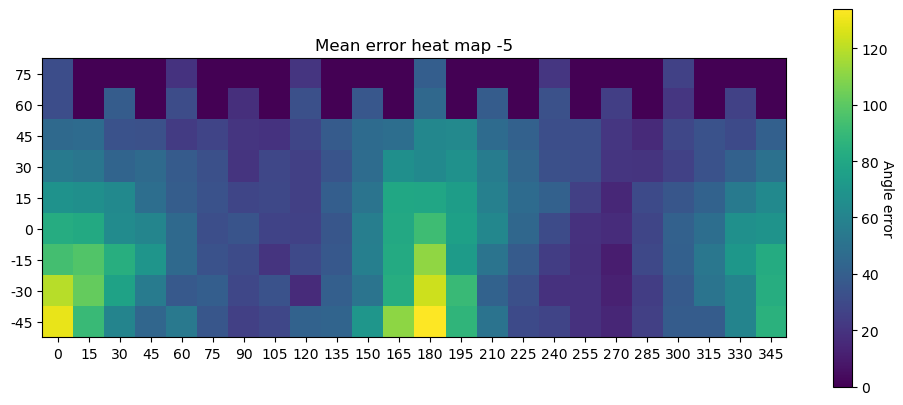

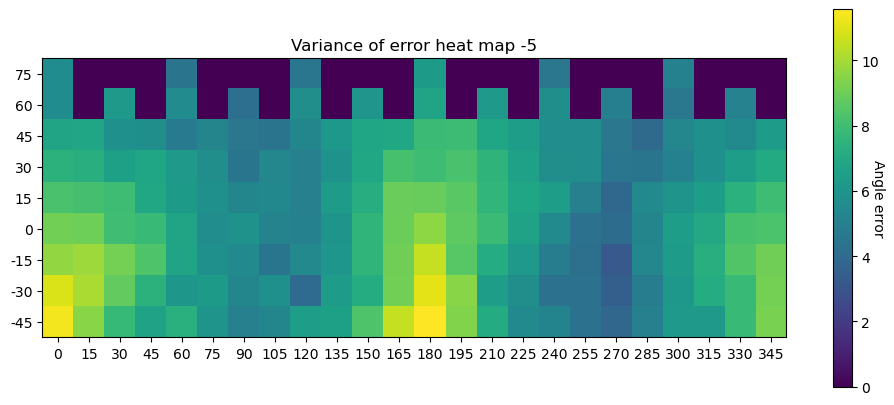

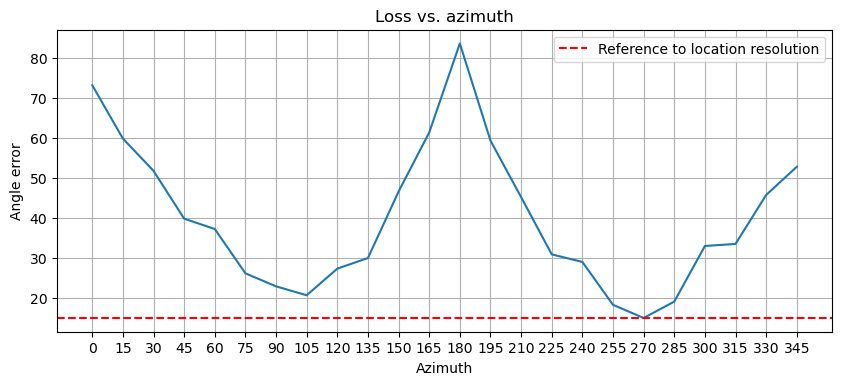

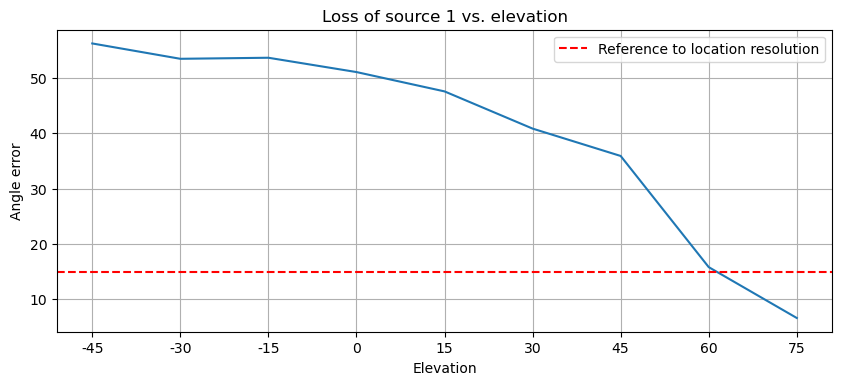

SystemExit: 

In [10]:
loss_dict = {}
loss_var_dict = {}
count_dict = {}
val_SNR_list = [-5,0,5,10,15,20,25,30,35]
for i in val_SNR_list:
    loss_dict[i] = np.zeros((9,24))
    loss_var_dict[i] = np.zeros((9,24))
    count_dict[i] = np.zeros((9,24))

for i in range(log_array.shape[0]):
    if elevOffset(log_array[i,4]) == 9:
        # print(f"skip: {log_array[i,4], log_array[i,6]}")
        continue

    loss_dict[int(log_array[i,0])][elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += log_array[i, 6]

    loss_var_dict[int(log_array[i,0])][elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += log_array[i, 6]**2
    
    count_dict[int(log_array[i,0])][elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += 1

for i in val_SNR_list:
    loss_heatmap = loss_dict[i]
    loss_heatmap_var = loss_dict[i]
    count = count_dict[i]
    loss_heatmap_ = np.divide(
        loss_heatmap, count, out=np.zeros_like(loss_heatmap), where=np.absolute(count)!=0
    )
    loss_heatmap_var_ = np.sqrt(np.divide(
        loss_heatmap_var, count, out=np.zeros_like(loss_heatmap), where=np.absolute(count)!=0
    ))

    vis_heatmap(loss_heatmap_, fig_title="Mean error heat map "+str(i))
    vis_heatmap(loss_heatmap_var_, fig_title="Variance of error heat map "+str(i))

    loss_azim = np.mean(loss_heatmap_, 0)
    loss_elev = np.mean(loss_heatmap_, 1)
    
    vis_line(loss_azim, x_label="Azimuth", fig_title="Loss vs. azimuth")
    vis_line(loss_elev, x_label="Elevation", fig_title="Loss of source 1 vs. elevation")
    raise SystemExit

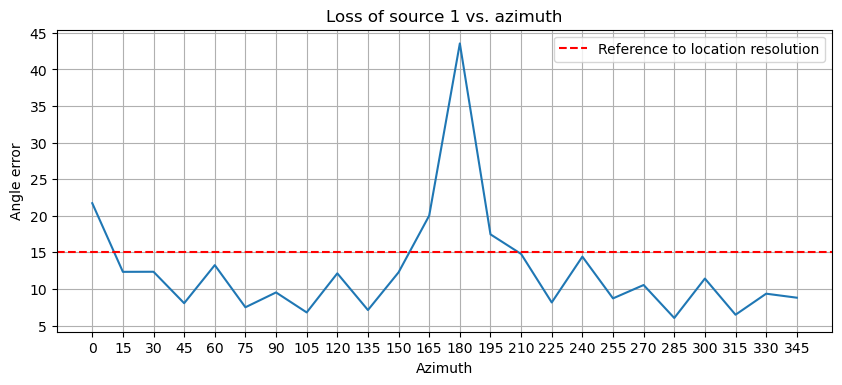

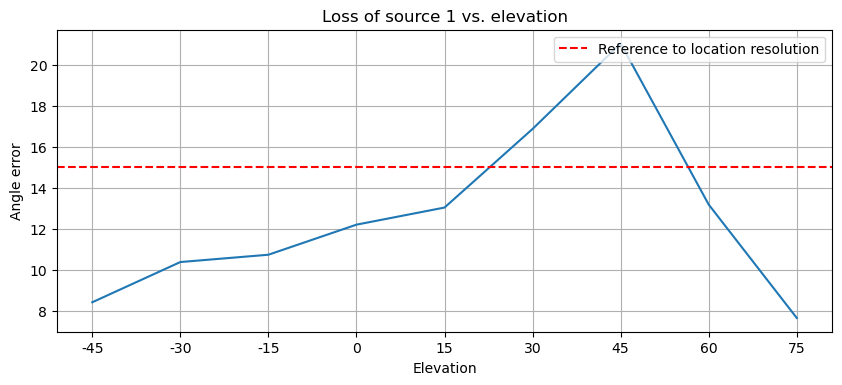

# CRNN

(13392, 7)


Text(0.5, 1.0, 'Angle error vs. elevation for the WGN-corrupted single sound source')

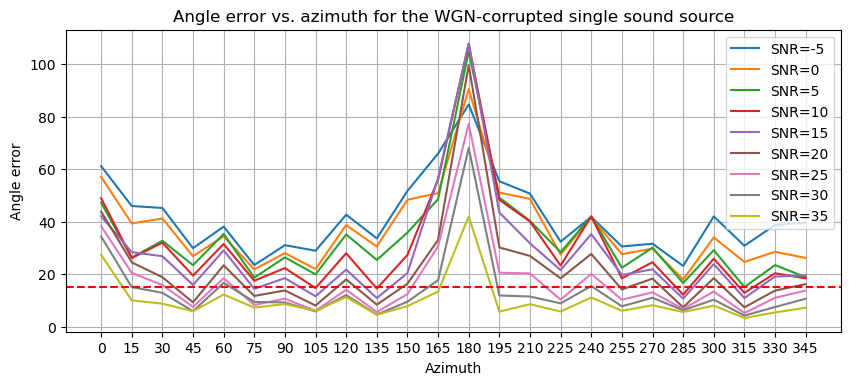

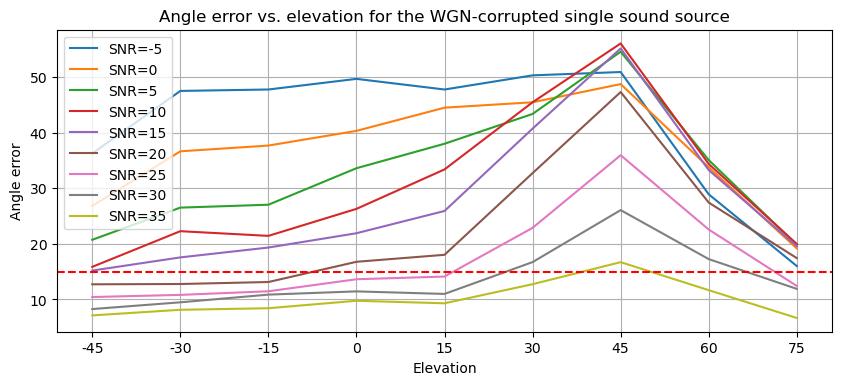

In [20]:
# path_crnn = "D:\SSSL-D\model\HPC/2308_1Sound_crnn_fc4/test_log_1Sound.csv"
path_crnn = "C:/Users/mynam/Desktop/female.csv"
path_tf = "./test_logs/test_log_1Sound.csv"
log_csv = pd.read_csv(path_tf, header=None)
# print(log_csv[:])
loss_heatmap = np.zeros((9,24))
loss_heatmap_var = np.zeros((9,24))
count = np.zeros((9,24))

log_array = (log_csv.iloc[:,:].values.astype(np.float))
print(log_array.shape)

loss_dict = {}
loss_var_dict = {}
count_dict = {}
val_SNR_list = [-5,0,5,10,15,20,25,30,35]
for i in val_SNR_list:
    loss_dict[i] = np.zeros((9,24))
    loss_var_dict[i] = np.zeros((9,24))
    count_dict[i] = np.zeros((9,24))

for i in range(log_array.shape[0]):
    if elevOffset(log_array[i,4]) == 9:
        # print(f"skip: {log_array[i,4], log_array[i,6]}")
        continue
    # if azimOffset(log_array[i,5]) == 12:
    #     # print(f"skip: {log_array[i,4], log_array[i,6]}")
    #     continue

    loss_dict[int(log_array[i,0])][elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += log_array[i, 6]

    loss_var_dict[int(log_array[i,0])][elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += log_array[i, 6]**2
    
    count_dict[int(log_array[i,0])][elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += 1


fig_azim, ax_azim = plt.subplots(figsize=(10, 4), dpi=100)
fig_elev, ax_elev = plt.subplots(figsize=(10, 4), dpi=100)
for i in val_SNR_list:
    loss_heatmap = loss_dict[i]
    loss_heatmap_var = loss_dict[i]
    count = count_dict[i]
    loss_heatmap_ = np.divide(
        loss_heatmap, count, out=np.zeros_like(loss_heatmap), where=np.absolute(count)!=0
    )
    loss_heatmap_var_ = np.sqrt(np.divide(
        loss_heatmap_var, count, out=np.zeros_like(loss_heatmap), where=np.absolute(count)!=0
    ))

    # vis_heatmap(loss_heatmap_, fig_title="Mean error heat map "+str(i))
    # vis_heatmap(loss_heatmap_var_, fig_title="Variance of error heat map "+str(i))

    loss_azim = np.mean(loss_heatmap_, 0)
    loss_elev = np.mean(loss_heatmap_, 1)

    ax_azim.plot(loss_azim, label='SNR='+str(i))
    ax_elev.plot(loss_elev, label='SNR='+str(i))
    # fig, ax = plt.figure(figsize=(10, 4), dpi=100)
    # vis_line(loss_azim, x_label="Azimuth", fig_title="Loss vs. azimuth")
    # vis_line(loss_elev, x_label="Elevation", fig_title="Loss of source 1 vs. elevation")
    # raise SystemExit

for ax in [ax_azim, ax_elev]:
    ax.legend()
    ax.grid()

x_ticks = range(0,360,15)
ax_azim.set_xticks(range(loss_azim.size))
ax_azim.set_xticklabels(x_ticks)
x_ticks = range(-45,90,15)
ax_elev.set_xticks(range(loss_elev.size))
ax_elev.set_xticklabels(x_ticks)
ax_azim.axhline(y=15, color='r', linestyle='--', label='Reference to location resolution')
ax_elev.axhline(y=15, color='r', linestyle='--', label='Reference to location resolution')
# ax_azim.xlabel("Azimuth")
# ax_elev.xticks(range(loss_elev.size), x_ticks)
# ax_elev.xlabel("Elevation")
# ax.ylabel("Angle error")
ax_azim.set_xlabel("Azimuth")
ax_elev.set_xlabel("Elevation")
ax_azim.set_ylabel("Angle error")
ax_elev.set_ylabel("Angle error")
ax_azim.set_title("Angle error vs. azimuth for the WGN-corrupted single sound source")
ax_elev.set_title("Angle error vs. elevation for the WGN-corrupted single sound source")

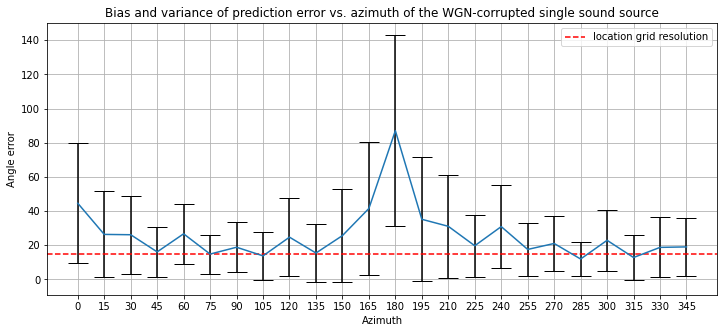

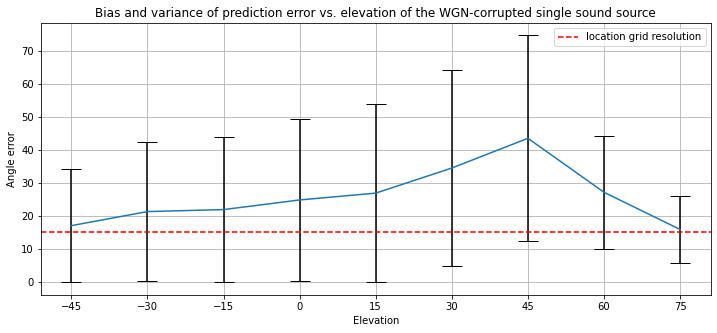

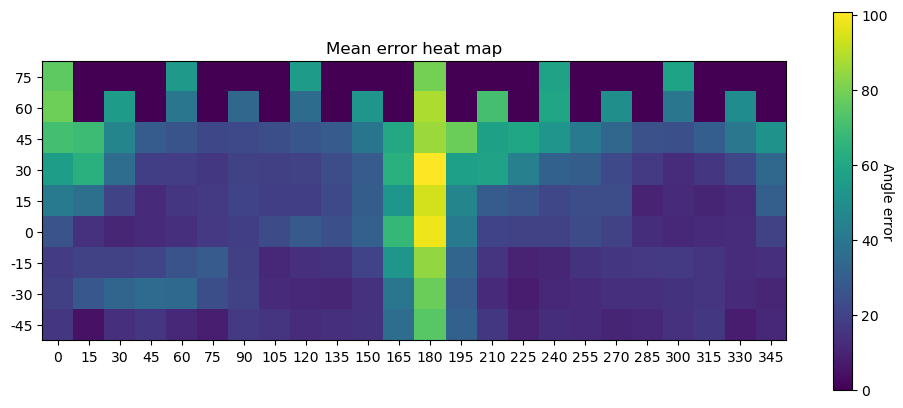

In [22]:
loss_all_snr = np.zeros((9,24))
loss_var_all_snr = np.zeros((9,24))
count_all_snr = np.zeros((9,24))
for i in range(log_array.shape[0]):
    if elevOffset(log_array[i,4]) == 9:
        # print(f"skip: {log_array[i,4], log_array[i,6]}")
        continue
    # if azimOffset(log_array[i,5]) == 12:
    #     # print(f"skip: {log_array[i,4], log_array[i,6]}")
    #     continue

    loss_all_snr[elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += log_array[i, 6]
    count_all_snr[elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += 1


for i in range(log_array.shape[0]):
    loss_var_all_snr[elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] \
        += (log_array[i, 6] - loss_all_snr[elevOffset(log_array[i,4]), azimOffset(log_array[i,5])] /count_all_snr[elevOffset(log_array[i,4]), azimOffset(log_array[i,5])])**2

# print(np.sqrt(loss_var_all_snr / count_all_snr))
# print(np.mean(np.divide(loss_all_snr, count_all_snr, where=np.absolute(count_all_snr)!=0), 0))
loss_all_snr = np.divide(loss_all_snr, count_all_snr, where=np.absolute(count_all_snr)!=0)
loss_var_all_snr = np.sqrt(np.divide(loss_var_all_snr, count_all_snr, where=np.absolute(count_all_snr)!=0))

plt.figure(figsize=(12,5))
plt.errorbar(range(0,360,15), np.mean(loss_all_snr, 0), yerr=np.mean(loss_var_all_snr, 0), alpha=1, ecolor='black', capsize=10)
plt.axhline(y=15, color='r', linestyle='--', label='location grid resolution')
plt.gca()
plt.xlabel("Azimuth")
plt.xticks(range(0,360,15))
plt.ylabel("Angle error")
plt.grid()
plt.legend()
plt.title("Bias and variance of prediction error vs. azimuth of the WGN-corrupted single sound source")

plt.figure(figsize=(12,5))
plt.errorbar(range(-45,90,15), np.mean(loss_all_snr, 1), yerr=np.mean(loss_var_all_snr, 1), alpha=1, ecolor='black', capsize=10)
plt.axhline(y=15, color='r', linestyle='--', label='location grid resolution')
plt.gca()
plt.xlabel("Elevation")
plt.xticks(range(-45,90,15))
plt.ylabel("Angle error")
plt.grid()
plt.legend()
plt.title("Bias and variance of prediction error vs. elevation of the WGN-corrupted single sound source")


vis_heatmap(loss_all_snr, fig_title="Mean error heat map")